In [1458]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [1512]:
# load dataset
height = 4
width = 4
depth = 24

start_bin = 4
end_bin = 16

In [1513]:
combined_all_hists_rel = np.empty((0, end_bin - start_bin, height, width))
combined_labels = np.empty((0, 3))

In [1597]:
all_hists = []
labels = []
zero_hists = []

zone_to_label = {
    0: [0, 0, 0],
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1],
    4: [1, 1, 0],
    5: [1, 0, 1],
    6: [0, 1, 1],
    7: [1, 1, 1],
}

In [1598]:
# for i in range(4):
#     hists = np.load(f'datasets/display-box-3/histograms_{i}.npy')
#     all_hists.append(hists)

#     if i == 0:
#         zero_hists.append(hists)

#     labels += [zone_to_label[i]] * len(hists)

In [1599]:
for i in range(4):
    hists = np.load(f'datasets/display-box-11/histograms_{i}.npy')

    hists = hists.reshape(-1, height, width, depth)
    # move depth to the front
    hists = np.moveaxis(hists, -1, 1)

    # look at first 10 bins
    # data = np.array(hists[:, :10, :, :])
    # data = np.array(hists[:, :, :, :])
    data = hists

    # Compute the mean and standard deviation for each position (10, 4, 4) across all samples
    mean = data.mean(axis=0)  # Shape: (10, 4, 4)
    std = data.std(axis=0)    # Shape: (10, 4, 4)

    # Compute the threshold for values being within 3 standard deviations
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Only consider the first n values along the 10-axis (shape: n x 4 x 4)
    n = 4
    data_to_check = data[:, :n, :, :]  # Shape: (4000, n, 4, 4)
    lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
    upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

    # Identify samples where all values in the first 3 indices along the 10-axis are within bounds
    valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

    # Apply the mask to filter the samples
    filtered_data = data[valid_mask]

    hists = filtered_data

    # sliding window mean smoothing
    # Compute the sliding window mean
    k = 5
    sliding_mean = np.array([
        hists[j - k + 1 : j + 1].mean(axis=0)  # Mean of the last k elements
        for j in range(k - 1, len(hists))
    ])
    
    hists = sliding_mean

    # generate more data by adding gaussian noise with std of the actual data std (changes for bin/pixel)
    std = hists.std(axis=0)
    hists = np.repeat(hists, 5, axis=0)
    hists += np.random.normal(0, std * 0.5, hists.shape)

    if i == 0:
        zero_hists.append(hists)

    else:
        all_hists.append(hists)
        labels += [zone_to_label[i]] * len(hists)

In [1600]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)

# all_hists = all_hists.reshape(-1, height, width, depth)
# # move depth to the front
# all_hists = np.moveaxis(all_hists, -1, 1)

# zero_hists = zero_hists.reshape(-1, height, width, depth)
# zero_hists = np.moveaxis(zero_hists, -1, 1)

In [1601]:
# # Compute the mean and standard deviation for each position (24, 4, 4) across all samples
# mean = all_hists.mean(axis=0)  # Shape: (24, 4, 4)
# std = all_hists.std(axis=0)    # Shape: (24, 4, 4)

# # Compute the threshold for values being within 3 standard deviations
# lower_bound = mean - 3 * std
# upper_bound = mean + 3 * std

# # Only consider the first n values along the depth axis (shape: n x 4 x 4)
# n = 4
# data_to_check = all_hists[:, :n, :, :]  # Shape: (4000, n, 4, 4)
# lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
# upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

# # Identify samples where all values in the first 3 indices along the depth axis are within bounds
# valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

# # Apply the mask to filter the samples
# filtered_all_hists = all_hists[valid_mask]
# filtered_labels = labels[valid_mask]

# # Check the shapes of the original and filtered arrays
# print(f"Original shape: {all_hists.shape}")
# print(f"Filtered shape: {filtered_all_hists.shape}")
# all_hists = filtered_all_hists
# labels = filtered_labels

In [1602]:
# crop first bounce bins (first bounce in first 2 bins)
# crop bins that are too far and noisy
all_hists = all_hists[:, start_bin:end_bin, :, :]
zero_hists = zero_hists[:, start_bin:end_bin, :, :]

In [1603]:
# generate more data by adding gaussian noise

# all_hists = np.repeat(all_hists, 5, axis=0)
# labels = np.repeat(labels, 5, axis=0)

# add noise
# std = 3 is good for general training?
# all_hists += np.random.normal(0, 1, all_hists.shape)

In [1604]:
all_hists = torch.tensor(all_hists, dtype=torch.float32)
zero_hists = torch.tensor(zero_hists, dtype=torch.float32)


In [1605]:
# pick 20 random zero hists to act as the zero mean
num_samples_to_mean = 20

random_zero_mean = torch.empty((all_hists.shape[0], all_hists.shape[1], height, width))

for i in range(all_hists.shape[0]):
    indices = torch.randint(0, zero_hists.shape[0], (num_samples_to_mean,))
    random_zero_mean[i] = zero_hists[indices].mean(dim=0)

In [1606]:
# # normalize to 0-1 values
# all_hist_mins = all_hists.amin(dim=(1, 2, 3), keepdim=True)
# all_hist_maxs = all_hists.amax(dim=(1, 2, 3), keepdim=True)
# all_hist_ranges = all_hist_maxs - all_hist_mins
# all_hist_ranges[all_hist_ranges == 0] = 1
# all_hists = (all_hists - all_hist_mins) / all_hist_ranges

# # normalize to 0-1 values
# random_zero_mean_mins = random_zero_mean.amin(dim=(1, 2, 3), keepdim=True)
# random_zero_mean_maxs = random_zero_mean.amax(dim=(1, 2, 3), keepdim=True)
# random_zero_mean_ranges = random_zero_mean_maxs - random_zero_mean_mins
# random_zero_mean_ranges[random_zero_mean_ranges == 0] = 1
# random_zero_mean = (random_zero_mean - random_zero_mean_mins) / random_zero_mean


In [1607]:
all_hists_rel = all_hists - random_zero_mean

In [1608]:
# mean all pixels
# all_hists_rel = all_hists_rel.mean(dim=(2, 3), keepdim=True)

In [1609]:
# zero_mean = np.mean(zero_hists, axis=0)

# # lower bound at 0
# # all_hists = np.maximum(all_hists, 0)
# # zero_mean = np.maximum(zero_mean, 0)
# all_hists_rel = all_hists - zero_mean

In [1610]:
# chunk sizes
print(f'shape of all_hists: {all_hists.shape}')
print(f'shape of labels: {labels.shape}')
print(f'shape of all_hists_rel: {all_hists_rel.shape}')

shape of all_hists: torch.Size([13940, 12, 4, 4])
shape of labels: (13940, 3)
shape of all_hists_rel: torch.Size([13940, 12, 4, 4])


In [1611]:
combined_all_hists_rel = np.concatenate([combined_all_hists_rel, all_hists_rel], axis=0)
combined_labels = np.concatenate([combined_labels, labels], axis=0)

In [1613]:
# final dataset sizes
print(f'shape of all_hists_rel: {combined_all_hists_rel.shape}')
print(f'shape of labels: {combined_labels.shape}')

shape of all_hists_rel: (85105, 12, 4, 4)
shape of labels: (85105, 3)


In [1614]:
# Convert numpy arrays to PyTorch tensors
# all_hists_tensor = torch.tensor(all_hists, dtype=torch.float32)
# all_hists_tensor = torch.tensor(all_hists_rel, dtype=torch.float32)
all_hists_tensor = torch.tensor(combined_all_hists_rel, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.long)
labels_tensor = torch.tensor(combined_labels, dtype=torch.float32)

# all_hists_tensor = torch.sign(all_hists_tensor) * torch.log1p(torch.abs(all_hists_tensor))


# epsilon = 0.1  # Smoothing factor
# labels_tensor = (1 - epsilon) * labels_tensor + epsilon * 0.5  # Smooth towards uniform distribution

# Create a TensorDataset
dataset = TensorDataset(all_hists_tensor, labels_tensor)

# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(1))

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [1615]:
for batch_x, batch_y in train_loader:
    print(f'batch_x shape: {batch_x.shape}')
    print(f'batch_y shape: {batch_y.shape}')
    break

batch_x shape: torch.Size([32, 12, 4, 4])
batch_y shape: torch.Size([32, 3])


In [1616]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [1617]:
# class CounterCNN(nn.Module):
#     def __init__(self):
#         super(CounterCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
#         self.batchnorm1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
#         self.batchnorm2 = nn.BatchNorm2d(64)
#         # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(64 * 4 * 4, 128)
#         self.fc1_bn = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
#         self.relu = nn.LeakyReLU(negative_slope=0.01)
#         self.dropout = nn.Dropout(p=0.7)

#     def forward(self, x):
#         # print(f'x shape at start: {x.shape}')
#         x = self.relu(self.conv1(x))
#         # print(f'x shape after conv1: {x.shape}')
#         x = self.batchnorm1(x)
#         # x = self.pool(x)
#         # print(f'x shape after pool1: {x.shape}')
#         x = self.relu(self.conv2(x))
#         # print(f'x shape after conv2: {x.shape}')
#         x = self.batchnorm2(x)
#         # x = self.pool(x)
#         # print(f'x shape after pool2: {x.shape}')
#         x = torch.flatten(x, 1)
#         # print(f'x shape after flatten: {x.shape}')
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc1_bn(x)
#         x = self.fc2(x)
#         return x

# # Instantiate the model
# model = CounterCNN().to(device)
# print(model)

In [1618]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(64)

        out_channels = 4
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.fc1 = nn.Linear(out_channels * (end_bin - start_bin) * height * width, 128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # # print(f'x shape at start: {x.shape}')
        # x = self.relu(self.conv1(x))
        # # print(f'x shape after conv1: {x.shape}')
        # x = self.batchnorm1(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool1: {x.shape}')
        # x = self.relu(self.conv2(x))
        # # print(f'x shape after conv2: {x.shape}')
        # x = self.batchnorm2(x)

        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)

        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CounterCNN().to(device)
print(model)

CounterCNN(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [1619]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(initialize_weights)

CounterCNN(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [1620]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)

In [1621]:
def train(dataloader, model, loss_fn, optimizer, counter=False, clipping=False, debug=False):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        if len(X) < batch_size:
            continue

        X, y = X.to(device), y.to(device)
        # print(f'X shape: {X.shape}, y shape: {y.shape}')
        # Compute prediction error
        pred = model(X)
        # if counter:
            # y = y.unsqueeze(1)
        # print(f'pred shape: {pred.shape}, y shape: {y.shape}')
        loss = loss_fn(pred, y)
        # print(f'loss: {loss.item()}')
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        if clipping:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed
        
        if debug:
            # Inspect gradients for each layer
            for name, param in model.named_parameters():
                if param.grad is not None:  # Only check if gradient is computed
                    print(f"Layer: {name} | Gradient mean: {param.grad.abs().mean().item()} | Gradient max: {param.grad.abs().max().item()}")
                else:
                    print(f"Layer: {name} has no gradient.")

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [1622]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [ ]:
def test_counter(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            # final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            final_pred = torch.round(torch.sigmoid(pred))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            exact_match = torch.all(final_pred == torch.round(y), dim=1)
            correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [1624]:
def train_early_stopping(train_loader, val_loader, model, loss_fn, optimizer, 
    epochs=50, early_stopping=True, patience=5, threshold=0.15, counter=False, clipping=False, debug=False):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, counter=counter, clipping=clipping, debug=debug)
        if counter:
            val_loss, correct = test_counter(val_loader, model, loss_fn)
        else:
            val_loss, correct = test(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                patience_counter = 0
            else:
                if val_loss / best_val_loss > 1 + threshold:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {t+1}")
                        break
        # print(f'patience_counter: {patience_counter}')
    return best_model, train_losses, val_losses

Epoch 1
-------------------------------
loss: 1.148295  [   32/42552]
loss: 0.522126  [ 3232/42552]
loss: 0.415015  [ 6432/42552]
loss: 0.480581  [ 9632/42552]
loss: 0.557398  [12832/42552]
loss: 0.538285  [16032/42552]
loss: 0.396060  [19232/42552]
loss: 0.586628  [22432/42552]
loss: 0.475524  [25632/42552]
loss: 0.276104  [28832/42552]
loss: 0.646092  [32032/42552]
loss: 0.450679  [35232/42552]
loss: 0.418510  [38432/42552]
loss: 0.482596  [41632/42552]
Test Error: 
 Accuracy: 40.3%, Avg loss: 0.404847 

Epoch 2
-------------------------------
loss: 0.544718  [   32/42552]
loss: 0.427432  [ 3232/42552]
loss: 0.558059  [ 6432/42552]
loss: 0.628621  [ 9632/42552]
loss: 0.516215  [12832/42552]
loss: 0.485799  [16032/42552]
loss: 0.483816  [19232/42552]
loss: 0.494134  [22432/42552]
loss: 0.463896  [25632/42552]
loss: 0.497203  [28832/42552]
loss: 0.554068  [32032/42552]
loss: 0.439509  [35232/42552]
loss: 0.462554  [38432/42552]
loss: 0.305180  [41632/42552]
Test Error: 
 Accuracy: 49.9

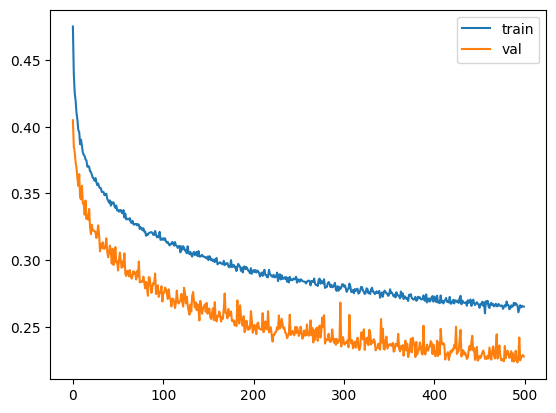

In [1625]:
best_model, train_losses, val_losses = train_early_stopping(
    train_loader, val_loader, model, loss_fn, optimizer, epochs=500, early_stopping=True,
    threshold=0.2,
    counter=True, clipping=True)

# plot training and validation losses
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


model = best_model

In [1626]:
model_save_path = 'models/display-box-18-rolling-means-half-noise-location.mdl'

In [1627]:
torch.save(model.state_dict(), model_save_path)

In [1628]:
model = CounterCNN().to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_12677/2522857457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

<All keys matched successfully>

In [1629]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test_counter(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.225552 



(0.2255519240646434, 0.7028716454387367)

In [1630]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data)

    # Get the predicted class
    predicted_class = output.argmax(dim=1).item()

    # Print the predicted class and the actual label
    print(f'Predicted class: {predicted_class}, Actual label: {example_label}')

Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 1, Actual label: tensor([0., 0., 1.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 1, Actual label: tensor([1., 0., 0.])
Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 2, Actual label: tensor([0., 0., 1.])
Predicted class: 0, Actual label: tensor([1., 0., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 1, Actual label: tensor([0., 1., 0.])
Predicted class: 1, Actual label: tensor([1., 0., 0.])
Predicted 

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        output = model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        # predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predicted_zones = torch.round(torch.sigmoid(output))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in test_dataset])

[[0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


In [1326]:
# FULL DATASET
# Create a DataLoader for the entire dataset
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in full_loader:
        X = X.to(device)
        output = model(X)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.cpu().numpy())

# Convert outputs to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in dataset])

[0 0 2 ... 2 2 2]


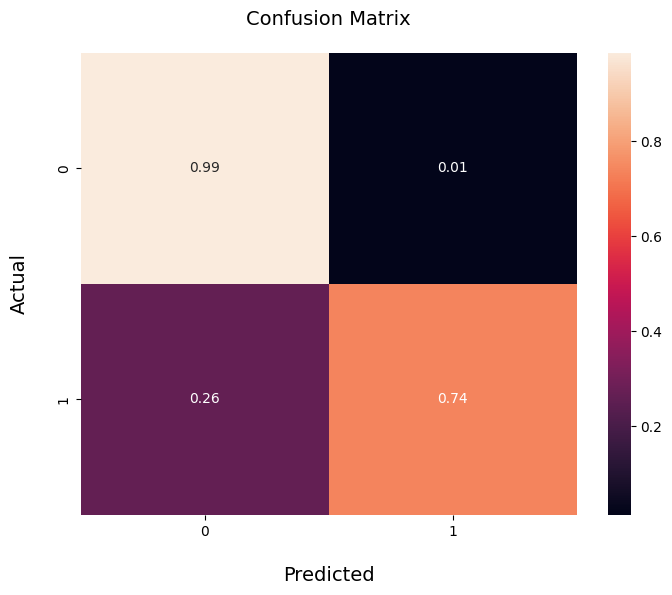

In [1632]:
y_test = np.array([y[0] for _, y in test_dataset]).astype(int)
y_preds = np.array([p[0] for p in predictions]).astype(int)
conf_matrix = confusion_matrix(y_test, y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# tick_labels = [0, 1, 2, 3, 4, 5, 6]
# tick_labels = [0, 1, 2]
tick_labels = [0, 1]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()

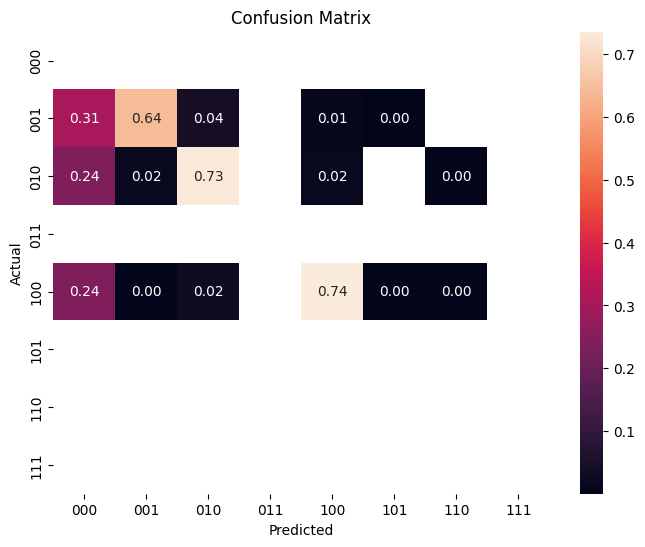

In [1633]:
categories = ["000", "001", "010", "011", "100", "101", "110", "111"]

y_test = np.array([y for _, y in test_dataset]).astype(int)
y_preds = np.array([p for p in predictions]).astype(int)

y_test = [''.join(map(str, label)) for label in y_test]
y_preds = [''.join(map(str, label)) for label in y_preds]


# Compute confusion matrix with all possible labels
conf_matrix = confusion_matrix(y_test, y_preds, labels=categories)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
conf_matrix_normalized = conf_matrix.astype('float') / row_sums
conf_matrix_normalized[conf_matrix == 0] = np.nan

# Plot the heatmap
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", mask=np.isnan(conf_matrix_normalized))

# Set tick labels
ax.set_xticks(np.arange(len(categories)) + 0.5)
ax.set_yticks(np.arange(len(categories)) + 0.5)
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

# Labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()
